# Training public data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Sisfall_dataset/processed_data.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
0,0.066406,-0.699219,-0.386719,-1.098633,-30.761719,-21.484375,SA01,D01,Walking,Walking
1,-0.195312,-1.394531,-0.027344,-10.864258,-46.752930,-3.173828,SA01,D01,Walking,Walking
2,0.335938,-0.890625,-0.246094,31.860352,-22.216797,8.056641,SA01,D01,Walking,Walking
3,0.273438,-1.000000,-0.062500,2.624512,-11.352539,29.052734,SA01,D01,Walking,Walking
4,0.046875,-0.828125,-0.074219,7.263184,15.869141,26.184082,SA01,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988281,-0.066406,-0.023438,26.916504,-10.498047,-15.625000,SA21,F12,Lateral fall,Fall
412898,1.031250,0.066406,0.203125,-14.953613,16.235352,26.184082,SA21,F12,Lateral fall,Fall
412899,0.941406,-0.187500,0.359375,-25.878906,32.409668,11.840820,SA21,F12,Lateral fall,Fall
412900,0.859375,-0.101562,0.375000,12.451172,37.841797,-2.136230,SA21,F12,Lateral fall,Fall


In [3]:
data = data[data['activity']!="D18"]
data = data[data['activity']!="D19"]
data = data[data['broad_mapped_activity']!='Gentle jump']
data = data[data['broad_mapped_activity']!='Jogging']
data = data[data['broad_mapped_activity']!='Stumble']
data = data[data['broad_mapped_activity']!='climbing stairs']
data.replace(to_replace='getting up', value = 'Sitting action', inplace = True)

In [4]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['Fall', 'Sitting action', 'Walking']

In [5]:
# split the data into training and test set
Training_data = data[~data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
print(Training_data.shape)
Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
Test_data

(188001, 10)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
16000,0.168,-0.918,-0.219,-0.488,5.127,-13.367,SA17,D01,Walking,Walking
16001,0.121,-0.906,-0.207,-4.211,6.775,-4.517,SA17,D01,Walking,Walking
16002,0.109,-0.953,-0.160,-9.766,2.808,0.854,SA17,D01,Walking,Walking
16003,0.113,-0.965,-0.184,-7.080,-6.897,5.798,SA17,D01,Walking,Walking
16004,0.129,-0.980,-0.168,-4.333,-14.709,5.005,SA17,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988,-0.066,-0.023,26.917,-10.498,-15.625,SA21,F12,Lateral fall,Fall
412898,1.031,0.066,0.203,-14.954,16.235,26.184,SA21,F12,Lateral fall,Fall
412899,0.941,-0.188,0.359,-25.879,32.410,11.841,SA21,F12,Lateral fall,Fall
412900,0.859,-0.102,0.375,12.451,37.842,-2.136,SA21,F12,Lateral fall,Fall


In [6]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))
# Training_data['encoded_label'] = 0
# activity = {'Sitting action': 0, 'Fall': 1, 'Walking': 2, 'climbing stairs': 3, 'getting up': 4}
# for i in range(0, len(Training_data)):
#     Training_data['encoded_label'].iloc[i] = activity[Training_data['broad_mapped_activity'].iloc[i]]

['Fall', 'Sitting action', 'Walking']


In [7]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [8]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.011600545010398882
standard deviation:  0.3545680463735675
accel_y
mean:  -0.7946766448383253
standard deviation:  0.4424120958419158
accel_z
mean:  -0.12944676407971234
standard deviation:  0.42574162842799623
gyro_x
mean:  0.10950525352508099
standard deviation:  30.437673283086834
gyro_y
mean:  1.120445297768529
standard deviation:  28.140653634239026
gyro_z
mean:  -0.2428202597866833
standard deviation:  22.231548577342227


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity,encoded_label
0,0.155,0.216,-0.604,-0.040,-1.133,-0.955,SA01,D01,Walking,Walking,2
1,-0.584,-1.356,0.240,-0.361,-1.701,-0.132,SA01,D01,Walking,Walking,2
2,0.915,-0.217,-0.274,1.043,-0.829,0.373,SA01,D01,Walking,Walking,2
3,0.738,-0.464,0.157,0.083,-0.443,1.318,SA01,D01,Walking,Walking,2
4,0.099,-0.076,0.130,0.235,0.524,1.189,SA01,D01,Walking,Walking,2
...,...,...,...,...,...,...,...,...,...,...,...
409897,2.744,2.132,-0.274,0.037,-0.109,-0.129,SA11,F12,Lateral fall,Fall,0
409898,2.722,2.211,-0.274,0.067,-0.064,-0.093,SA11,F12,Lateral fall,Fall,0
409899,2.755,2.167,-0.283,0.101,-0.020,-0.030,SA11,F12,Lateral fall,Fall,0
409900,2.699,2.185,-0.292,0.109,0.043,-0.008,SA11,F12,Lateral fall,Fall,0


In [9]:
print(mu)
print(sigma)

[0.011600545010398882, -0.7946766448383253, -0.12944676407971234, 0.10950525352508099, 1.120445297768529, -0.2428202597866833]
[0.3545680463735675, 0.4424120958419158, 0.42574162842799623, 30.437673283086834, 28.140653634239026, 22.231548577342227]


In [10]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [11]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (12530, 60, 6)
y shape:  (12530,)


In [12]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(12530, 360)

In [13]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (12530, 3)


### 1D-CNN Model

In [14]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(120, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60, 6)             0         
                                                                 
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 120)           36120     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 120)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 80)             2

In [15]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
63/63 [==============================] - 5s 18ms/step - loss: 0.7476 - accuracy: 0.7262
Epoch 2/100
63/63 [==============================] - 1s 13ms/step - loss: 0.4278 - accuracy: 0.8633
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3621 - accuracy: 0.8820
Epoch 4/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3317 - accuracy: 0.8909
Epoch 5/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3141 - accuracy: 0.8966
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2954 - accuracy: 0.9000
Epoch 7/100
63/63 [==============================] - 1s 15ms/step - loss: 0.2849 - accuracy: 0.9045
Epoch 8/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2781 - accuracy: 0.9053
Epoch 9/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2718 - accuracy: 0.9096
Epoch 10/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2649 - accuracy: 0.9103

63/63 [==============================] - 1s 14ms/step - loss: 0.0788 - accuracy: 0.9734
Epoch 83/100
63/63 [==============================] - 1s 13ms/step - loss: 0.0813 - accuracy: 0.9717
Epoch 84/100
63/63 [==============================] - 1s 13ms/step - loss: 0.0796 - accuracy: 0.9721


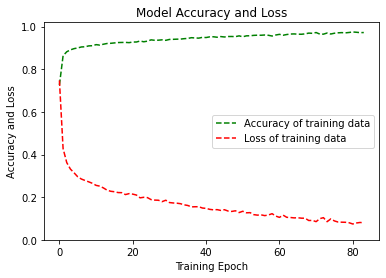

In [16]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [17]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'Sitting action', 'Walking']
accel_x
mean:  0.011600545010398882
standard deviation:  0.3545680463735675
accel_y
mean:  -0.7946766448383253
standard deviation:  0.4424120958419158
accel_z
mean:  -0.12944676407971234
standard deviation:  0.42574162842799623
gyro_x
mean:  0.10950525352508099
standard deviation:  30.437673283086834
gyro_y
mean:  1.120445297768529
standard deviation:  28.140653634239026
gyro_z
mean:  -0.2428202597866833
standard deviation:  22.231548577342227
x shape:  (6263, 60, 6)
y shape:  (6263,)


(6263, 3)

In [18]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 1s 4ms/step - loss: 0.3030 - accuracy: 0.9232

Accuracy on test data: 0.92

Loss on test data: 0.30


In [19]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

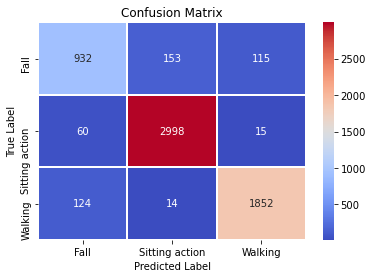


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.84      0.78      0.80      1200
           1       0.95      0.98      0.96      3073
           2       0.93      0.93      0.93      1990

    accuracy                           0.92      6263
   macro avg       0.91      0.89      0.90      6263
weighted avg       0.92      0.92      0.92      6263



In [20]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [21]:
model_m.save('best_model_cnn_online_data.h5')

### LSTM Model

In [22]:
model_lstm = Sequential()
model_lstm.add(LSTM(400, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(200, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400)               651200    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(12530, 60, 6)

In [24]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
63/63 [==============================] - 10s 114ms/step - loss: 0.7217 - accuracy: 0.7049
Epoch 2/50
63/63 [==============================] - 7s 113ms/step - loss: 0.3665 - accuracy: 0.8706
Epoch 3/50
63/63 [==============================] - 7s 114ms/step - loss: 0.3223 - accuracy: 0.8895
Epoch 4/50
63/63 [==============================] - 7s 114ms/step - loss: 0.3002 - accuracy: 0.8972
Epoch 5/50
63/63 [==============================] - 7s 114ms/step - loss: 0.2747 - accuracy: 0.9075
Epoch 6/50
63/63 [==============================] - 7s 115ms/step - loss: 0.2656 - accuracy: 0.9088
Epoch 7/50
63/63 [==============================] - 7s 116ms/step - loss: 0.2538 - accuracy: 0.9138
Epoch 8/50
63/63 [==============================] - 7s 118ms/step - loss: 0.2351 - accuracy: 0.9184
Epoch 9/50
63/63 [==============================] - 8s 121ms/step - loss: 0.2253 - accuracy: 0.9215
Epoch 10/50
63/63 [==============================] - 8s 121ms/step - loss: 0.2194 - accuracy: 0.923

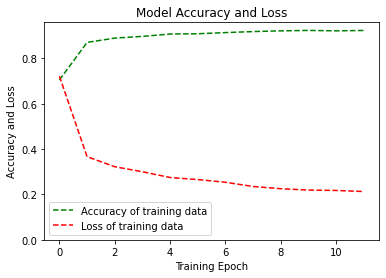

In [25]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [26]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(6263, 60, 6)

In [27]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 3s 12ms/step - loss: 0.3048 - accuracy: 0.8994

Accuracy on test data: 0.90

Loss on test data: 0.30


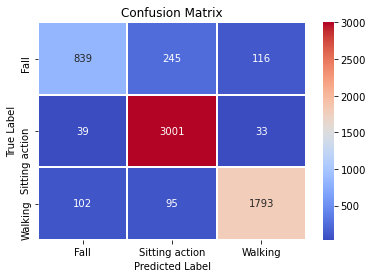


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1200
           1       0.90      0.98      0.94      3073
           2       0.92      0.90      0.91      1990

    accuracy                           0.90      6263
   macro avg       0.89      0.86      0.87      6263
weighted avg       0.90      0.90      0.90      6263



In [28]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [29]:
model_lstm.save('best_model_lstm_online_data.h5')

### 1D CNN + LSTM Model

In [30]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(LSTM(200, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(80, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 58, 100)           1900      
                                                                 
 lstm_1 (LSTM)               (None, 58, 200)           240800    
                                                                 
 conv1d_4 (Conv1D)           (None, 56, 100)           60100     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 100)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 100)           30100     
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                             

In [31]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(12530, 60, 6)

In [32]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_lsnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
63/63 [==============================] - 7s 74ms/step - loss: 1.0068 - accuracy: 0.4966
Epoch 2/50
63/63 [==============================] - 4s 68ms/step - loss: 0.6499 - accuracy: 0.7579
Epoch 3/50
63/63 [==============================] - 4s 68ms/step - loss: 0.4571 - accuracy: 0.8299
Epoch 4/50
63/63 [==============================] - 4s 70ms/step - loss: 0.4095 - accuracy: 0.8514
Epoch 5/50
63/63 [==============================] - 4s 71ms/step - loss: 0.3890 - accuracy: 0.8588
Epoch 6/50
63/63 [==============================] - 5s 72ms/step - loss: 0.3882 - accuracy: 0.8619
Epoch 7/50
63/63 [==============================] - 5s 72ms/step - loss: 0.3689 - accuracy: 0.8686
Epoch 8/50
63/63 [==============================] - 5s 74ms/step - loss: 0.3519 - accuracy: 0.8757
Epoch 9/50
63/63 [==============================] - 5s 75ms/step - loss: 0.3517 - accuracy: 0.8742
Epoch 10/50
63/63 [==============================] - 5s 76ms/step - loss: 0.3327 - accuracy: 0.8843
Epoch 11/

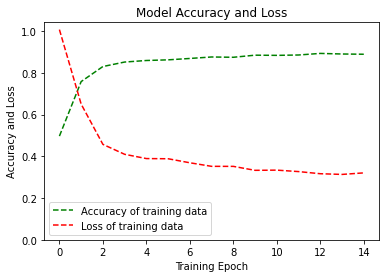

In [33]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [34]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(6263, 60, 6)

In [35]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 3s 9ms/step - loss: 0.3874 - accuracy: 0.8735

Accuracy on test data: 0.87

Loss on test data: 0.39


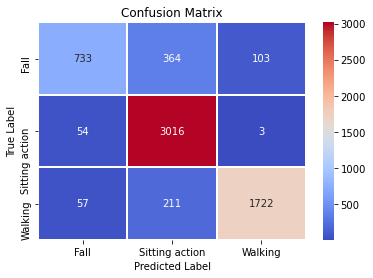


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.87      0.61      0.72      1200
           1       0.84      0.98      0.91      3073
           2       0.94      0.87      0.90      1990

    accuracy                           0.87      6263
   macro avg       0.88      0.82      0.84      6263
weighted avg       0.88      0.87      0.87      6263



In [36]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [37]:
model_lsnet.save('best_model_lsnet_online_data.h5')

### RNN Model (not used)

In [38]:
model_rnn = keras.Sequential()
model_rnn.add(Embedding(input_dim=TIME_PERIODS*no_of_features, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model_rnn.add(GRU(128, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(len(LABELS), activation='softmax'))

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          23040     
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 110,083
Trainable params: 110,083
Non-trainable params: 0
_________________________________________________________________


In [39]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(12530, 360)

In [40]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

# opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_rnn.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
63/63 [==============================] - 51s 768ms/step - loss: 0.9650 - accuracy: 0.5677
Epoch 2/50
63/63 [==============================] - 54s 856ms/step - loss: 0.8704 - accuracy: 0.6541
Epoch 3/50
63/63 [==============================] - 54s 860ms/step - loss: 0.8368 - accuracy: 0.6603
Epoch 4/50
63/63 [==============================] - 54s 850ms/step - loss: 0.7185 - accuracy: 0.7168
Epoch 5/50
63/63 [==============================] - 56s 881ms/step - loss: 0.6756 - accuracy: 0.7254
Epoch 6/50
63/63 [==============================] - 65s 1s/step - loss: 0.6355 - accuracy: 0.7444
Epoch 7/50
63/63 [==============================] - 56s 890ms/step - loss: 0.6344 - accuracy: 0.7454
Epoch 8/50
63/63 [==============================] - 55s 865ms/step - loss: 0.5839 - accuracy: 0.7644
Epoch 9/50
63/63 [==============================] - 58s 921ms/step - loss: 0.5659 - accuracy: 0.7797
Epoch 10/50
63/63 [==============================] - 57s 903ms/step - loss: 0.5596 - accuracy:

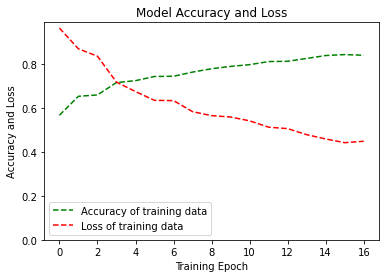

In [41]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [42]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)
x_test.shape

(6263, 360)

In [43]:
score = model_rnn.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 13s 62ms/step - loss: 0.5728 - accuracy: 0.7918

Accuracy on test data: 0.79

Loss on test data: 0.57


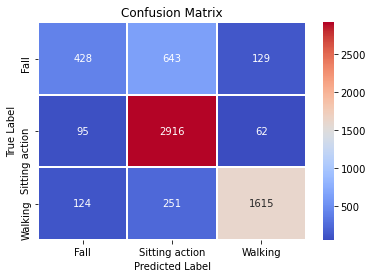


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.66      0.36      0.46      1200
           1       0.77      0.95      0.85      3073
           2       0.89      0.81      0.85      1990

    accuracy                           0.79      6263
   macro avg       0.77      0.71      0.72      6263
weighted avg       0.79      0.79      0.77      6263



In [44]:
y_pred_test = model_rnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))